# Fine Tuning for fundus image classification

Trains a CNN model for image classificaiton (Disease, NotDisease)

## 数据准备

只需要运行一次

------------------------

    Date: April, 2021

    N: Normal. 500
    Y: ROP. 500. Include: Stage 1: 106. Stage 2: 167. Stage 3: 150. Stage 4: 77.
    
    Saved to '../data/fundus/C2/C2_202104.pkl'
 ------------------------   
    
    Date: August, 2021

    N: Normal. 1000
    Y: Stage 1: 216. Stage 2: 663. Stage 3: 846. Stage 4: 77.
    
    Saved to '../data/fundus/C5/C5_202108.pkl'
    
    In this study, we combine Stage1 & Stage2, Stage3 & Stage4

In [1]:
%run transfer_learner.py
learner = transfer_learner("fundus_C3_customEfficientNetB4_model", W = 224)

## 数据读取，并保存到pkl（只需要运行一次）

## 从pkl直接数据读取，读取训练集、验证集、类标签等

In [2]:
learner.load_dataset_from_pkl(PKL_PATH = "fundus_efficientnet_dataset.pkl")

## C5 -> C3

In [3]:
import math

learner.class_names = ['Normal', 'Stage1~2', 'Stage3~4']
learner.num_classes = len(learner.class_names)

def combine_class(c):
    return math.ceil(c/2.0)

y_train_c = list(map(combine_class, learner.y_train.argmax(-1)))
# convert class labels to on-hot encoding
learner.y_train = to_categorical(y_train_c, learner.num_classes)

y_val_c = list(map(combine_class, learner.y_val.argmax(-1)))
# convert class labels to on-hot encoding
learner.y_val = to_categorical(y_val_c, learner.num_classes)

In [26]:
hist = learner.train("EfficientNetB4", 
    batch = 8, epochs = [10,0], optimizer = "adam")

78872576/78864416 [==============================] - 27s 0us/step
Epoch 1/10
231/231 [==============================] - 182s 788ms/step - loss: 0.8019 - accuracy: 0.6621 - val_loss: 0.5763 - val_accuracy: 0.7636
Epoch 2/10
231/231 [==============================] - 176s 762ms/step - loss: 0.5854 - accuracy: 0.7565 - val_loss: 0.5578 - val_accuracy: 0.7679
Epoch 3/10
231/231 [==============================] - 175s 757ms/step - loss: 0.5448 - accuracy: 0.7684 - val_loss: 0.5242 - val_accuracy: 0.7852
Epoch 4/10
231/231 [==============================] - 175s 757ms/step - loss: 0.4951 - accuracy: 0.8010 - val_loss: 0.5188 - val_accuracy: 0.7961
Epoch 5/10
231/231 [==============================] - 175s 756ms/step - loss: 0.4531 - accuracy: 0.8210 - val_loss: 0.4248 - val_accuracy: 0.8308
Epoch 6/10
231/231 [==============================] - 173s 750ms/step - loss: 0.4165 - accuracy: 0.8303 - val_loss: 0.4831 - val_accuracy: 0.8221
Epoch 7/10
231/231 [==============================] - 181s

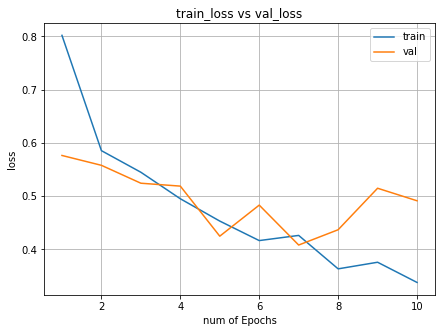

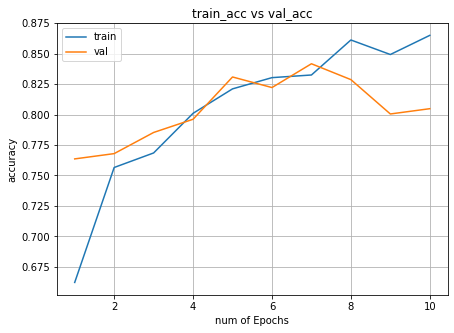

In [27]:
plot_history(hist)

## Continue Training

If the model doesn't reach the best, continue training

In [ ]:
learner.continue_train(epochs=[0,10]) # continue training in Phase II (unfreeze all layers)

Epoch 1/10
231/231 [==============================] - 175s 758ms/step - loss: 0.3746 - accuracy: 0.8433 - val_loss: 0.4313 - val_accuracy: 0.8373
Epoch 2/10
231/231 [==============================] - 172s 744ms/step - loss: 0.3504 - accuracy: 0.8563 - val_loss: 0.4122 - val_accuracy: 0.8330
Epoch 3/10
231/231 [==============================] - 183s 792ms/step - loss: 0.3417 - accuracy: 0.8736 - val_loss: 0.4136 - val_accuracy: 0.8330
Epoch 4/10
231/231 [==============================] - 169s 733ms/step - loss: 0.3268 - accuracy: 0.8704 - val_loss: 0.4656 - val_accuracy: 0.8113
Epoch 5/10
231/231 [==============================] - 187s 807ms/step - loss: 0.3237 - accuracy: 0.8628 - val_loss: 0.5641 - val_accuracy: 0.8200
Epoch 6/10
231/231 [==============================] - 187s 811ms/step - loss: 0.2966 - accuracy: 0.8850 - val_loss: 0.4016 - val_accuracy: 0.8547
Epoch 7/10
231/231 [==============================] - 174s 755ms/step - loss: 0.2900 - accuracy: 0.8894 - val_loss: 0.4254 -

# get the best model

In [28]:
learner.get_best_model().summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## Test on validation set

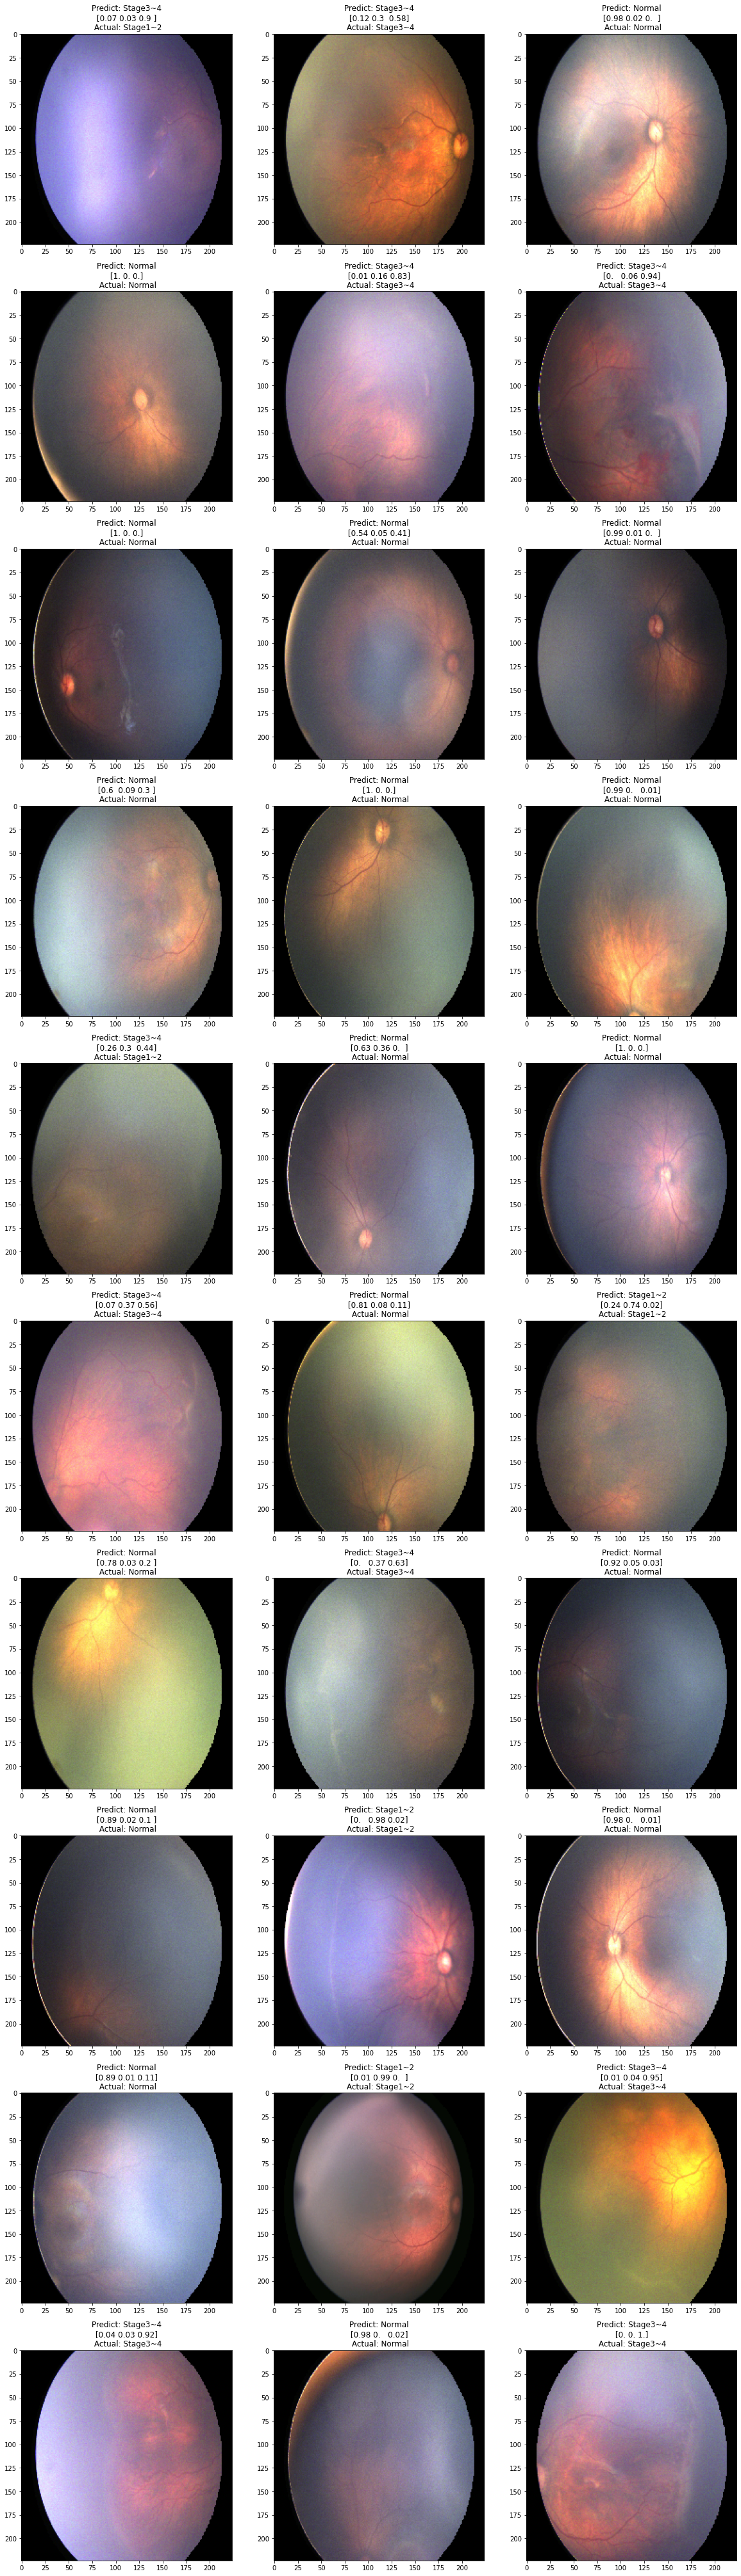

In [29]:
learner.evaluate(N = 30) # batch_size 10

best threshold = 0.37

# Binary Classification Test

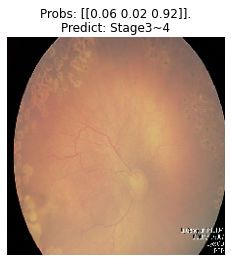

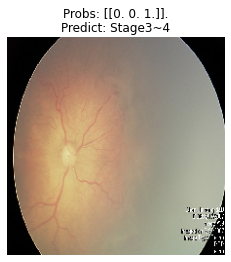

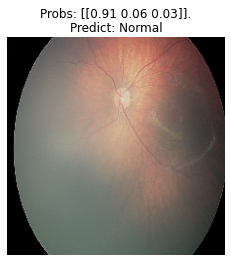

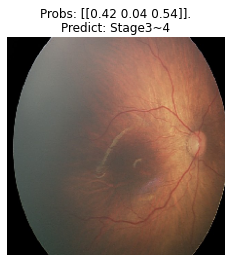

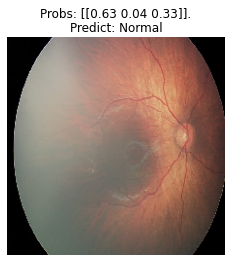

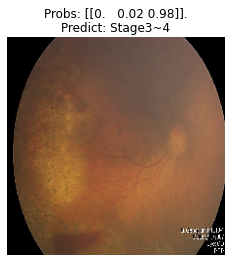

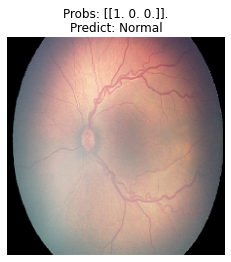

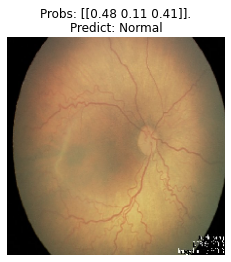

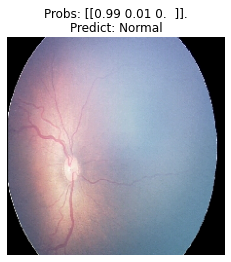

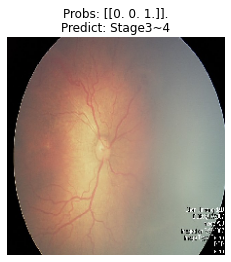

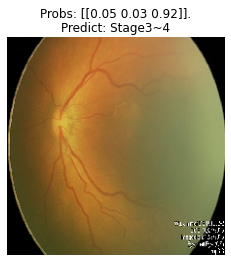

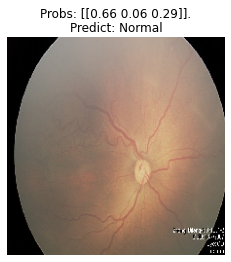

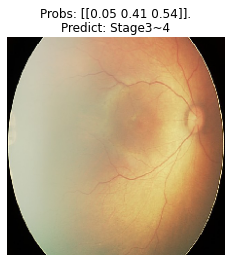

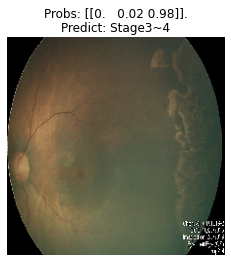

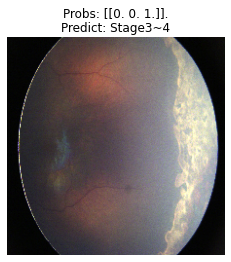

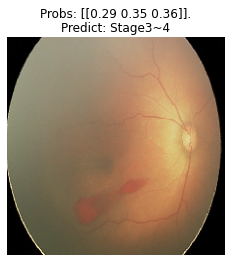

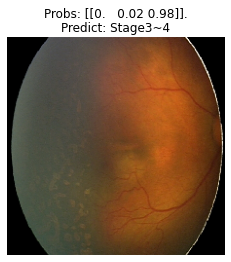

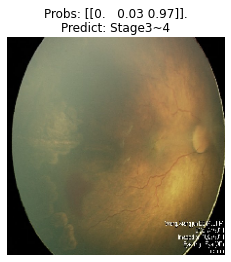

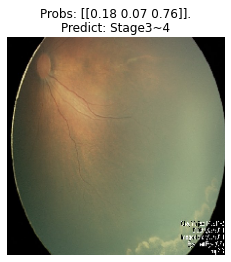

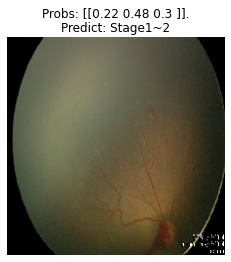

Averaged prob on disease set = 0.6666667


In [30]:
DIR = '../../data/fundus/C5/Disease/'  # dont't use ../data/fundus/C2T/Y/, which is included in the training set. Now is deleted

ps = []
for idx, img in enumerate(os.listdir(DIR)):
    img_path = DIR + '/'+ img        

    p = learner.predict_file(img_path, display = idx < 20, use_mask = True) # 只显示前10个数据
    ps.append(1 - p[0])
    
print('Averaged prob on disease set =', np.mean(ps))

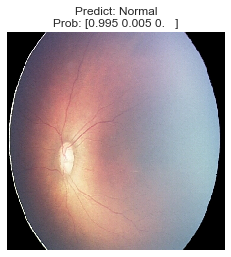

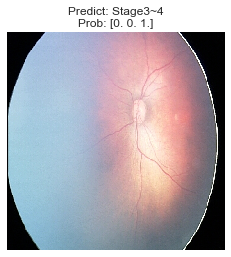

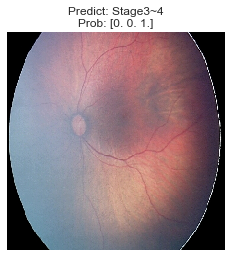

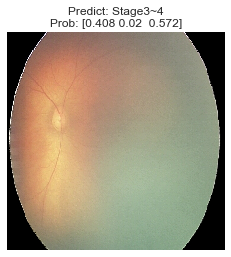

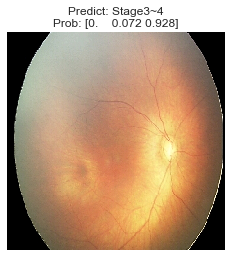

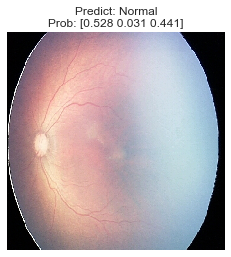

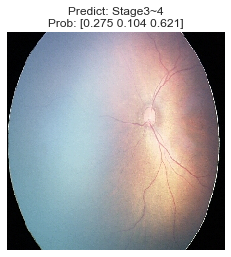

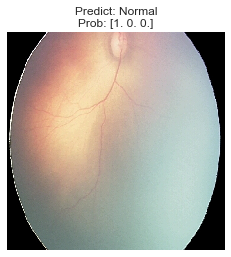

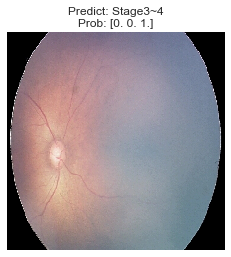

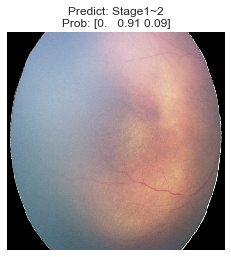

Averaged prob on normal set = 0.27238324


In [12]:
DIR = '../data/fundus/C5/NotDisease/' # dont't use ../data/fundus/C2T/N/, which is included in the training set. Now is deleted

ps = []
for idx, img in enumerate(os.listdir(DIR)):
    img_path = DIR + '/'+ img        

    # p = predict(custom_vgg_model, img_path, names, display = idx < 10) # 只显示前10个数据
    p = predict_file(best_models, img_path, names, display = idx < 10, mask = None) # 只显示前10个数据
    ps.append(p[0]) # 0 - Normal
    
print('Averaged prob on normal set =', np.mean(ps))

# Convert to tflite

In [31]:
learner.convert_to_tflite()

AttributeError: 'function' object has no attribute 'call'